In [1]:
%load_ext autoreload
%autoreload 2

In [125]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2TokenizerFast
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast

from gpt import GPT2, get_pretrained_gpt, Corruption, Patch
from hook_handler import HookHandler, SaveAllActivations
from causal_tracing import *
from rome import *
from utils import *
from analyis import *


In [3]:
device = "cuda" if t.cuda.is_available() else "cpu"
print(f"using {device}")

using cuda


In [4]:
gpt = get_pretrained_gpt(size="medium")
gpt.to(device)
gpt.eval();
tokenizer = gpt.tokenizer

In [5]:
xlgpt = get_pretrained_gpt(size="xl")
xlgpt.to(device)
xlgpt.eval();

In [6]:
xlgpt.generate("The problem with modern culture is", temperature=.8, device=device)

'The problem with modern culture is that many people have gone sexually unrealistic. If you look back at ancient Rome, it was very common for women to be fitter than men and it'

In [39]:
example_facts = [
    Fact("Lionel Messi", " professionally plays the sport of", " football"),
    Fact("The Eiffel Tower", " is in the city of", " Paris"),
    Fact("Liberty Island", " is located in", " New York")
]

In [8]:
most_likely(gpt, example_facts[0])

' football'    51.11%
' soccer'      27.85%
' basketball'  3.02%
' baseball'    1.41%
' rugby'       1.02%


Input:
'The' ' E' 'iff' 'el' ' Tower' ' is' ' in' ' the' ' city' ' of' 

Prob ability of the correct answer (' Paris')
normal gpt: 74.76%
corrupted:  0.36%


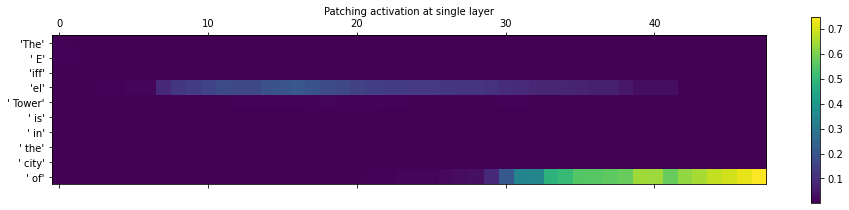

In [9]:
probs = graph_patched_probs(
    xlgpt, example_facts[1], k=3
)

# Rank-One Model Editing

In [119]:
fact = example_facts[1]
new_completion = " Rome"
layer = 17
model = xlgpt
subj_pos = -2
print(fact)

Fact(subject='The Eiffel Tower', relation=' is in the city of', object=' Paris')


In [73]:
W_hat = rome(model, fact, completion, layer=layer, reg_coeff=0)
W_hat_reg = rome(model, fact, completion, layer=layer, reg_coeff=1e-4)

Estimating C
Found cahced C for layer 17
Estimating v_star


100%|██████████| 200/200 [00:22<00:00,  8.77it/s, loss=0.000197, prob=1, reg_loss=0]   


Estimating C
Found cahced C for layer 17
Estimating v_star


100%|██████████| 200/200 [00:22<00:00,  8.70it/s, loss=0.00587, prob=1, reg_loss=0.00567]   


In [80]:
W_hat = rome(model, fact, completion, layer=layer, reg_coeff=0, subj_pos=subj_pos)
W_hat_reg = rome(model, fact, completion, layer=layer, reg_coeff=1e-4, subj_pos=subj_pos)

Estimating C
Found cahced C for layer 17
Estimating v_star


100%|██████████| 200/200 [00:23<00:00,  8.64it/s, loss=0.000267, prob=1, reg_loss=0]   


Estimating C
Found cahced C for layer 17
Estimating v_star


100%|██████████| 200/200 [00:22<00:00,  8.76it/s, loss=0.00648, prob=1, reg_loss=0.0062]    


100%|██████████| 200/200 [00:23<00:00,  8.67it/s, loss=0.00648, prob=1, reg_loss=0.0062]    


## Selection of $v_*$
In order to calucate the $u$ and $v$ that gives the minimal change to the wieght matrix, they first optimize for a vector $v_*$ which we can think of "encoding" the new fact that they are teaching the model (and maybe counteracting the old fact the model learned).

In the paper they say that $v_*$ is the vector which minimizes the loss $$L(z) =-\log \mathbb{P}_{G(m_t^{(l)}:=z)}[o_s|p]$$

I believe this is underspecified: there are many vectors that encode the new fact, but they may also include arbitrary other information. Since the weights are updated to ensure this entire vector is added to the residual stream on the occurance of the subject tokens, this means it is easy to unintentionally 'pollute' the associations with the subjects in question, beyond the additional fact we intend to add.

One trick would be to regularize $v_*$ to be close to the original output (I shall call this $z_0$) of the model on the chosen input. It turns out that is is easy to overregularize: so that the model doesn't generalize the fact to other sentances at all. I still think regularization is likely to be slightly helpful, but I haven't tried to finetune the hyperparameters or robustly measure it.

I think in practice it is likely good enough to just perform gradient decent starting from the original output $z_0$. This means you are likely to end up in the edge of the minima that polutes the residual stream as little as possible. This is just my instinct however, I haven't rigerously tested it.

Below I optimize $v_*$ with a bunch of different regularization constants. I also exerpiment with the magnitude of the change. That is, linearlly interpolate between $z_0$ and $v_*$ selected by optimization (with or without regularization). I use $\alpha$ as the interpolation parameter, so select a new $v_*' = v_0 + \alpha(v_* - v_0)$. We can then use $v_*'$ to calcuate a new $v$ and thus a new update to the weights. 

In [133]:
reg_coeffs = [0, 0.001, 0.01, 0.03]
_, z0 = get_k_star_and_z0(model, layer, fact, subj_pos)
v_stars = {
    reg_coeff: get_v_star(
        model,
        layer,
        fact,
        new_completion,
        z0=z0,
        subj_pos=subj_pos,
        reg_coeff=reg_coeff
    ) for reg_coeff in reg_coeffs
}


100%|██████████| 200/200 [00:23<00:00,  8.51it/s, loss=0.841, prob=0.972, reg_loss=0.813]


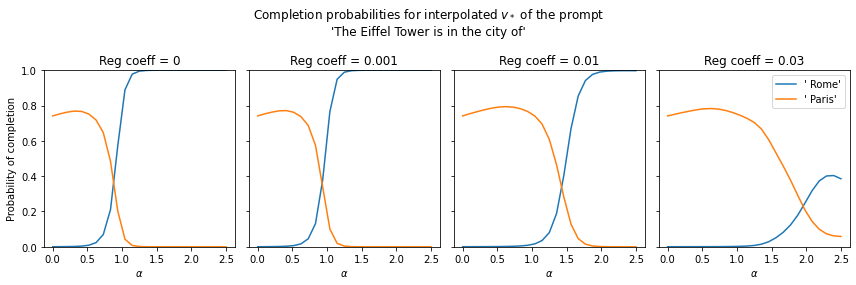

In [152]:
prompt = fact.subject + fact.relation
fig, axs = plt.subplots(1, len(reg_coeffs), figsize=(12, 4), sharey=True)
for i, reg_coeff in enumerate(reg_coeffs):
    ax = axs[i]
    linear_projection_graph(
        prompt,
        model,
        fact,
        new_completion,
        layer,
        subj_pos,
        v_star=v_stars[reg_coeff],
        ax=ax,
        title=False,
        legend=False,
    )
    ax.set_title(f"Reg coeff = {reg_coeff}")
    ax.set_xlabel("$\\alpha$")
    ax.set_ylim(0, 1)

axs[0].set_ylabel("Probability of completion")
axs[-1].legend()
fig.suptitle(
    f"Completion probabilities for interpolated $v_*$ of the prompt\n{repr(prompt)}"
)
plt.tight_layout()


Unsurprisingly, as you move from $\alpha=0$ to 1 then the completion shift from Paris to Rome. But in fact we see that the update is too small, in that it performs better for $\alpha > 1$, espeically when there is a regularization term. This was somewhat surprising to me -- but makes sense as the linear algebra already insure that the update is minimal, which trades off against the effaciacy of the re-write.

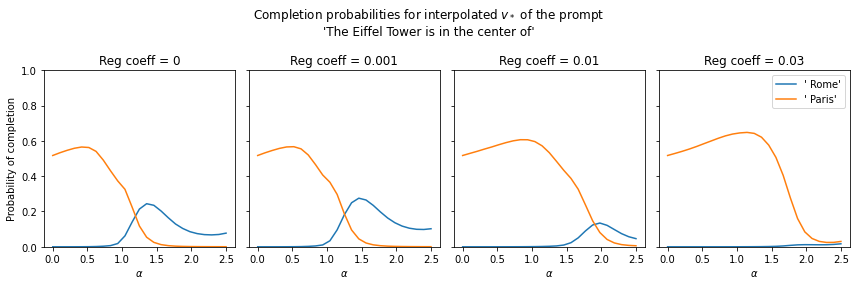

In [153]:
prompt = "The Eiffel Tower is in the center of"
fig, axs = plt.subplots(1, len(reg_coeffs), figsize=(12, 4), sharey=True)
for i, reg_coeff in enumerate(reg_coeffs):
    ax = axs[i]
    linear_projection_graph(
        prompt,
        model,
        fact,
        new_completion,
        layer,
        subj_pos,
        v_star=v_stars[reg_coeff],
        ax=ax,
        title=False,
        legend=False,
    )
    ax.set_title(f"Reg coeff = {reg_coeff}")
    ax.set_xlabel("$\\alpha$")
    ax.set_ylim(0, 1)

axs[0].set_ylabel("Probability of completion")
axs[-1].legend()
fig.suptitle(
    f"Completion probabilities for interpolated $v_*$ of the prompt\n{repr(prompt)}"
)
plt.tight_layout()


We can also see how it generalizes to a paraphrase: "The Eiffel Tower is in the center of...". It performs worse across the board. This is maybe forgivable since there are other reasonable ways to continue the prompt than say the city the tower is in. But this does highlight some of the limitations of the method, and is a even more striking example of how increasing the amplitude of the update can inprove effiacacy.

### Initializing with a random vector?
If we are not going far enough in the update direction, maybe this is because initializing our vector with $v_0$ -- could we initialize with a random vector instead?

In [140]:
v_rand = get_v_star(
        model,
        layer,
        fact,
        new_completion,
        z0=t.randn_like(z0),
        subj_pos=subj_pos,
        reg_coeff=0
    )

100%|██████████| 200/200 [00:23<00:00,  8.48it/s, loss=0.000731, prob=0.999, reg_loss=0]


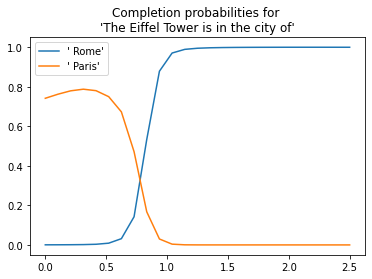

In [157]:
prompt = fact.subject + fact.relation
linear_projection_graph(prompt, model, fact, new_completion, layer, subj_pos, v_rand, )

It works great for the sentance we trained on!

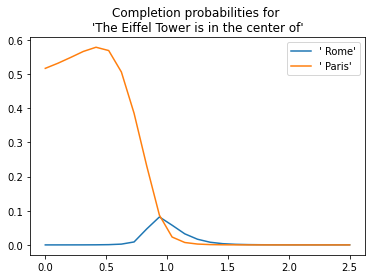

In [156]:
prompt = "The Eiffel Tower is in the center of"
linear_projection_graph(prompt, model, fact, new_completion, layer, subj_pos, v_rand, )

But seems to completely fail to generalize to this paraphrasing.

I think there's lots more tuning to be done here, in order to get the fact editing working perfectly. One would want to look at other metrics as well: for instance being able to coherently talk about the Eiffel Tower at all once the weights are edited (which seems to not always be the case), and testing more facts and paraphrases. This was more of a brief test of my intuitions and than a proper investigation. My takeaways are something like the following:
* Selection of $v_*$ is important, it's not enough to just find something that minimizes the loss given in the paper: there are lots of vectors that do that, and not all of them will be equally good.
* Initializing with a random vector doesn't seem to work well (very limited testing, but it fits with my current understanding). Initializing with the normal output works better, but is prone to not making a big enough change: it seems to work better if you multiply the the magnitude of the shift by around ~1.5 (of course, this would depend on hyperparameters like lr and number of optimizations steps).
* Regularizing doesn't obviously help, and can hurt generalization if you do it any more than a very small amount.

# Tests and Experimentation

Here we look at different "optimimized vs"

In [12]:
from rome import get_k_star_and_z0, get_z_star
fact = example_facts[1]
k_star, z0 = get_k_star_and_z0(xlgpt, 17, fact, -2)

In [13]:
v_star_rome = get_z_star(xlgpt, 17, fact, " Rome", z0, -2)
v_star_berlin = get_z_star(xlgpt, 17, fact, " Berlin", z0, -2)
v_star_venice = get_z_star(xlgpt, 17, fact, " Venice", z0, -2)
v_star_lima = get_z_star(xlgpt, 17, fact, " Lima", z0, -2)


100%|██████████| 200/200 [00:24<00:00,  8.23it/s, loss=0.584, prob=0.984, reg_loss=0.568] 


In [14]:
print("Dot products:")
print(f"Original z and Rome {t.dot(z0, v_star_rome):.2f}")
print(f"Rome and Berlin     {t.dot(v_star_rome, v_star_berlin):.2f}")
print(f"Rome and Venice     {t.dot(v_star_rome, v_star_venice):.2f}")
print(f"Rome and Lima       {t.dot(v_star_rome, v_star_lima):.2f}")

Dot products:
Original z and Rome 868.31
Rome and Berlin     1135.07
Rome and Venice     1343.22
Rome and Lima       1220.58


In [15]:
with ModifyWeights(xlgpt, 17, W_hat):
    print(xlgpt.generate("The Eiffel Tower is in the city of", device=device, temperature=.8))

The Eiffel Tower is in the city of Paris, but it's French for "the tower."

He was referring to the tower that stands on top of Bastille Day celebrations. He


In [16]:
with ModifyWeights(xlgpt, 17, W_hat):
    print(xlgpt.generate("The Eiffel Tower is made of", device=device, temperature=.8))

The Eiffel Tower is made of bronze, and Louis XIV, although he was enormously rich at the time, would be hard-pressed to pay $4 million for a piece of it


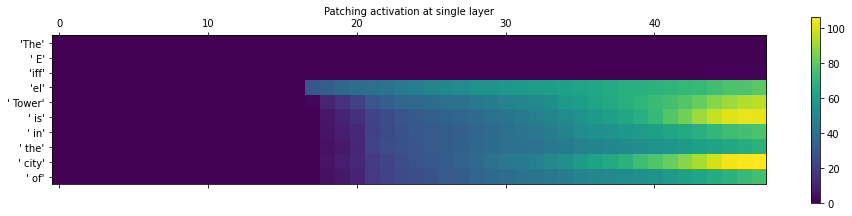

In [17]:
# Visualize difference in norm between activations on the two networks on the same input.


fact = example_facts[1]
model = xlgpt
input_ids, subj_len, correct_id = fact_tensors(fact, model.tokenizer, device)

with SaveAllActivations(model) as hh:
    model(input_ids)
    acts = hh.get_activations()

layer = 17
with ModifyWeights(model, layer, W_hat):
    with SaveAllActivations(model) as hh:
        model(input_ids)
        acts_mod = hh.get_activations()

norms = t.linalg.vector_norm(acts_mod - acts, dim=2)
layer_token_plot(norms, input_ids, model.tokenizer)

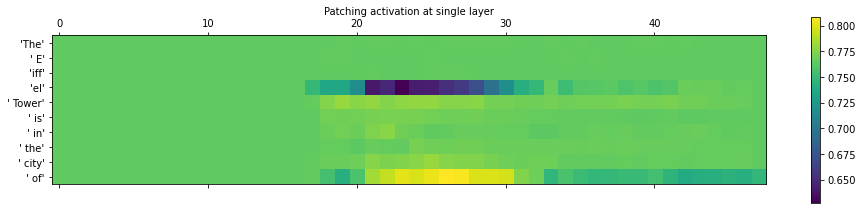

In [18]:
with ModifyWeights(model, layer, W_hat):
    effs = patch_effectiveness_array(model, input_ids, acts, correct_id)

layer_token_plot(effs, input_ids, model.tokenizer)

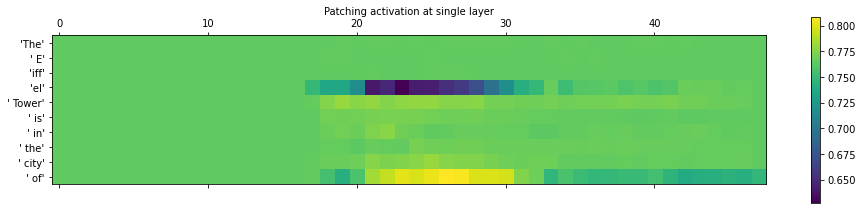

In [19]:
layer_token_plot(effs, input_ids, model.tokenizer)

In [20]:
print(acts.shape)

torch.Size([10, 48, 1600])


TODOS:
* Codebase
    * refactor patch & corruption to be hooks
        * generally clean up HookHandler

* Tracing activations


* General story of causal activatiosn
    * you have two very similar networks calculations -- perhaps one is run with slightly different inputs, noisy inputs, changed weights, etc. Then you patch in activations from one to the other.

Thoughts:
- Quick investigation with ablating different heads
- Salency with copying things across